In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import io


# Load the Data

In [60]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['Help!', 'बचाओ!']


In [61]:
print (lines[0][1])

	बचाओ!



# Figure out the Best Lengths of Sentences

## Compute Sentence Lengths

In [62]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [63]:
print(len(input_lengths))

2869


[75, 80, 0, 120]

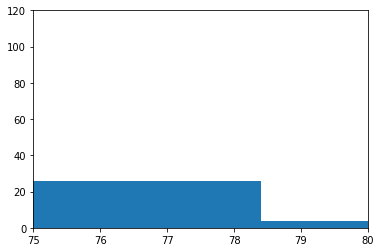

In [64]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

[85, 89, 0, 20]

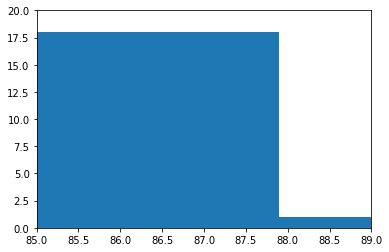

In [65]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [66]:
english = 78
hindi = 87

In [67]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [68]:
print(len(line1))

2856


## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [69]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [70]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [71]:
input_characters = set()
target_characters = set()

In [72]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [73]:
print(len(input_characters))
print(len(target_characters))

72
92


In [74]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [75]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2856
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [76]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [77]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [78]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [79]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [80]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [83]:
epochs = 200

In [84]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 2284 samples, validate on 572 samples
Epoch 1/200
2284/2284 [==============================] - 24s 10ms/step - loss: 1.1518 - val_loss: 1.8910
Epoch 2/200
2284/2284 [==============================] - 23s 10ms/step - loss: 1.1064 - val_loss: 1.7642
Epoch 3/200
2284/2284 [==============================] - 20s 9ms/step - loss: 1.0220 - val_loss: 1.6587
Epoch 4/200
2284/2284 [==============================] - 14s 6ms/step - loss: 0.9376 - val_loss: 1.5321
Epoch 5/200
2284/2284 [==============================] - 14s 6ms/step - loss: 0.8756 - val_loss: 1.4986
Epoch 6/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.8321 - val_loss: 1.3841
Epoch 7/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.7887 - val_loss: 1.3275
Epoch 8/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.7597 - val_loss: 1.2994
Epoch 9/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.7365 - val_loss: 1.2744
Epoch 10/200
22

2284/2284 [==============================] - 15s 6ms/step - loss: 0.2517 - val_loss: 1.4360
Epoch 79/200
2284/2284 [==============================] - 15s 6ms/step - loss: 0.2466 - val_loss: 1.4299
Epoch 80/200
2284/2284 [==============================] - 14s 6ms/step - loss: 0.2414 - val_loss: 1.4665
Epoch 81/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2381 - val_loss: 1.4747
Epoch 82/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2359 - val_loss: 1.4819
Epoch 83/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2316 - val_loss: 1.4939
Epoch 84/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2290 - val_loss: 1.5155
Epoch 85/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2260 - val_loss: 1.4982
Epoch 86/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.2216 - val_loss: 1.5012
Epoch 87/200
2284/2284 [==============================] - 15s 7ms/st

2284/2284 [==============================] - 15s 7ms/step - loss: 0.1189 - val_loss: 2.0256
Epoch 156/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.1187 - val_loss: 2.0120
Epoch 157/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.1373 - val_loss: 2.0203
Epoch 158/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.1883 - val_loss: 1.9657
Epoch 159/200
2284/2284 [==============================] - 16s 7ms/step - loss: 0.1343 - val_loss: 1.9627
Epoch 160/200
2284/2284 [==============================] - 16s 7ms/step - loss: 0.1288 - val_loss: 2.0115
Epoch 161/200
2284/2284 [==============================] - 15s 7ms/step - loss: 0.1195 - val_loss: 2.0385
Epoch 162/200
2284/2284 [==============================] - 16s 7ms/step - loss: 0.1176 - val_loss: 2.0446
Epoch 163/200
2284/2284 [==============================] - 16s 7ms/step - loss: 0.1167 - val_loss: 2.0435
Epoch 164/200
2284/2284 [==============================] - 1

In [85]:
model.save('s2s.h5')
model.save_weights('seq2seq.h5')


D:\aane\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [86]:

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [87]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
               stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [88]:
for seq_index in range(55,60):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
	I love you.

मैं उससे मिलना चाहूँगा।

-
	I love you.

मैं उससे मिलना चाहूँगा।

-
	I will try.

मैं अंग्रेज़ी पढ़ सकता हूँ।

-
	I'm coming.

मैं अंग्रेज़ी पढ़ सकता हूँ।

-
	I'm hungry!

मैं उससे मिलना चाहूँगा।

